In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.lines as mlines
import os

# https://stackoverflow.com/questions/47391702/matplotlib-making-a-colored-markers-legend-from-scratch

In [2]:
def lambda_scale_factor2blob_size(scale_factors):
    return (np.array(scale_factors)**3)*10
    

def draw(compression_value, shape_size_list, value_list, marker= 'o', edgecolor= 'r', facecolor='none', ymax= 0.5, ymin= 0.0):
    r_list= np.array([compression_value]*len(value_list))
    plt.scatter(r_list, value_list, s= shape_size_list, facecolors=facecolor, edgecolors=edgecolor, marker= marker, linewidths=3, alpha= 0.7)
    plt.vlines(compression_value, ymin=ymin, ymax= ymax, linestyles='--', alpha= 0.1)
    
def compact_plot(heatmap, Ts, lambda_scale_factors, plot_params):
    edgecolor = plot_params['edgecolor']
    facecolor = plot_params['facecolor']
    marker = plot_params['marker']

    T_grid = torch.tile(Ts.reshape(-1, 1), (1, len(lambda_scale_factors)))
    lmbda_scale_grid =  torch.tile(lambda_scale_factors.reshape(1, -1), (len(Ts), 1))

    compression_grid = T_grid/(2**(2*(lmbda_scale_grid-1)))

    unique_compression_values = sorted(list(set(compression_grid.flatten().numpy())), reverse= True)
    for compression_value in unique_compression_values:
        heatmap_vals = heatmap[compression_grid == compression_value]
        corres_scale_facts = lambda_scale_factors[torch.where(compression_grid == compression_value)[1]]
        shape_size_list = lambda_scale_factor2blob_size(corres_scale_facts)
        
        s = draw(np.log(compression_value), shape_size_list, heatmap_vals.numpy(), marker= marker, edgecolor= edgecolor, facecolor=facecolor, ymax= heatmap.max(), ymin= heatmap.min())
    return s

def plot_all_compact(plot_param_list, Ts, lambda_scale_factors, ylabel= 'MSE'):
    legends_colorshapes= []
    legends_sizes= []
    

    plt.figure(figsize= (10, 6))

    for plot_params in plot_param_list: 
        s = compact_plot(plot_params['heatmap'], Ts, lambda_scale_factors, plot_params= plot_params)
        legends_colorshapes.append(mlines.Line2D([], [], markeredgecolor= plot_params['edgecolor'], markerfacecolor= plot_params['facecolor'], marker=plot_params['marker'], linestyle='None',
                                markersize=10, label=plot_params['name'], markeredgewidth=2))
    
    marker_size_list = lambda_scale_factor2blob_size(np.array(lambda_scale_factors))**0.5  # marker_size= blob_size **0.5 in matplotlib
    for i in range(len(marker_size_list)):
        scale_factor= lambda_scale_factors[i]
        marker_size = marker_size_list[i]
        legends_sizes.append(mlines.Line2D([], [], markeredgecolor= 'black', markerfacecolor= 'white', marker= 'o', linestyle='None',
                                markersize=marker_size, label=f'lambda_scale_factor : {scale_factor}', markeredgewidth=3))
        
    if 'MSE' in ylabel:
        locs=[3,1]
    elif 'SSIM' in ylabel:
        locs=[2, 4]
    else:
        locs=[3,1]
    legend1 = plt.legend(handles=legends_colorshapes, loc=locs[0])
    plt.gca().add_artist(legend1)
    plt.legend(handles=legends_sizes, loc=locs[1])
    plt.ylabel(ylabel, fontsize= 20)
    plt.xlabel('log(Compression Ratio) [<0 is compressed]', fontsize= 20)

In [3]:
exp_set_dir = 'figs/neuronalv2'

Ts = torch.tensor([1,2,4])
lambda_scale_factors= torch.tensor([1,2,3,4,5,6,7])

In [8]:
import glob
heatmaps= sorted(glob.glob(f'{exp_set_dir}/heatmaps/SSIM*.npy'), key= lambda x: x.split('/')[-1].split('@@')[-1])
heatmaps

['figs/neuronalv2/heatmaps/SSIM11@@rotation_lambda(10000.0)@img_size(256)@num_samples_train(3000)@@highlrH.npy',
 'figs/neuronalv2/heatmaps/SSIM11@@rotation_lambda(10000.0)@img_size(256)@num_samples_train(3000)@@lowlrH.npy']

In [9]:
interested_heatmaps = [heatmaps[1], heatmaps[0]]
interested_heatmaps

['figs/neuronalv2/heatmaps/SSIM11@@rotation_lambda(10000.0)@img_size(256)@num_samples_train(3000)@@lowlrH.npy',
 'figs/neuronalv2/heatmaps/SSIM11@@rotation_lambda(10000.0)@img_size(256)@num_samples_train(3000)@@highlrH.npy']

In [10]:
edgecolors= ['r', 'g']
markers= ['o', 'o']

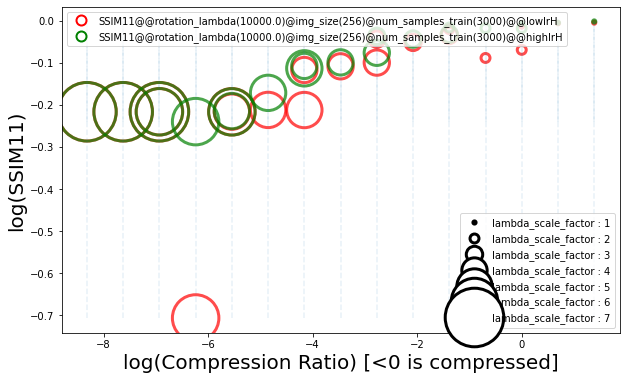

In [11]:
assert len(interested_heatmaps) == len(edgecolors), 'n_heatmaps != n_colors'

plot_param_list = []
for idx in range(len(interested_heatmaps)):
    np_dir= interested_heatmaps[idx]

    metrics_measured = np_dir.split('/')[-1].split('@@')[0]
    plot_ylabel= f'log({metrics_measured})'

    heatmap = np.load(np_dir)
    name= np_dir.split('/')[-1][:-4]
    plot_param_list.append({'heatmap': torch.tensor(np.log(heatmap)), 'edgecolor': edgecolors[idx], 'facecolor':'none', 'marker':markers[idx], 'name': name})

plot_all_compact(plot_param_list, Ts, lambda_scale_factors, ylabel= plot_ylabel)

exp_set_dir_name= exp_set_dir.split('/')[-1]
plot_name= '@@'.join(np_dir.split('/')[-1].split('@@')[0:2])

try:os.mkdir(f'{exp_set_dir}/compact_plots/')
except:pass

plt.savefig(f'{exp_set_dir}/compact_plots/compactplots_{exp_set_dir_name}_{plot_name}.png')
plt.show()